[Get scipy optimizer to minimize the function](#SPO)<br>
[Convex function](#Convex function)<br>
[Building a parameterized model](#Building a parameterized model)<br>
[Polynomials](#Polynomials)<br>

In [19]:
from IPython.core.display import HTML
import os

import os
# import re
import pprint as pp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 6)

from IPython.display import Image
from urllib import urlretrieve

HTML(os.path.join(os.pardir, r'golems/css_theme.txt'))

Populating the interactive namespace from numpy and matplotlib


In [21]:
def get_data(symbols, dates):
    """Read stock data (adjusted close) for given symbols from CSV files."""
    df = pd.DataFrame(index = dates)
    if 'SPY' not in symbols:          # add SPY for reference, if absent
        symbols.insert(0,'SPY')       # insert SPY in position 0 of symbol list
    for symbol in symbols:
        df_temp = pd.read_csv(symbol_to_path(symbol), 
                          index_col = 'Date',
                          parse_dates = True,
                          usecols = ['Date', 'Adj Close'],
                          na_values = ['nan'])
        df_temp = df_temp.rename(columns = {'Adj Close' : symbol})
        if symbol == 'SPY': df = df.join(df_temp, how = 'inner')
        # use an inner join with SPY data to get rid of non-market trading days
        # alternate solution: df.dropna(subset = ['SPY']) # drops rows with NaNs
        else: df = df.join(df_temp)
    return df.sort_index() # return results sorted by ascending datetime index

def symbol_to_path(symbol, base_dir = "data"):
    """Return CSV file path given ticker symbol"""
    return os.path.join(base_dir, "{}.csv".format(str(symbol)))

def plot_data(df):
    """plot stock prices"""
    df.plot()
    plt.show()  # must be called to show plots in some environments

def plot_data2(df, title = "Stock Chart", xlabel = "x label", ylabel = "y label", size = 14):
    ax = df.plot(title = title, fontsize = 12)
    ax.set_xlabel(xlabel, fontsize = size)
    ax.set_ylabel(ylabel, fontsize = size) 
    plt.show()  # must be called to show plots in some environments
    
def compute_daily_returns(df):
    daily_returns = df.copy() # to make a copy that doesn't change when df does
    daily_returns[1:] = (df[1:] / df[:-1].values) - 1
    daily_returns.ix[0, :] = 0  # set daily resturns from row 0 to 0
    return daily_returns

<img src='pics/Snap35.jpg' alt='Drawing' style='width: 300pt;'/>

<img src='pics/Snap36.jpg' alt='Drawing' style='width: 300pt;'/>

Optimizer (Gradient descent) calls the function many times to see which values of x minimize values of f(x).

## Get scipy's optimizer to minimize the function <a id='SPO'></a>

X = [ 2.], y = [ 0.75]
X = [ 2.], y = [ 0.75]
X = [ 2.00000001], y = [ 0.75000001]
X = [ 0.99999999], y = [ 0.75000001]
X = [ 1.5], y = [ 0.5]
X = [ 1.5], y = [ 0.5]
X = [ 1.50000001], y = [ 0.5]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: [ 0.5]
            Iterations: 2
            Function evaluations: 7
            Gradient evaluations: 2
Minima found at:
X = [ 1.5], Y = [ 0.5]
X = [ 0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3  1.4  1.5  1.6  1.7  1.8  1.9
  2.   2.1  2.2  2.3  2.4  2.5], y = [ 1.5   1.31  1.14  0.99  0.86  0.75  0.66  0.59  0.54  0.51  0.5   0.51
  0.54  0.59  0.66  0.75  0.86  0.99  1.14  1.31  1.5 ]


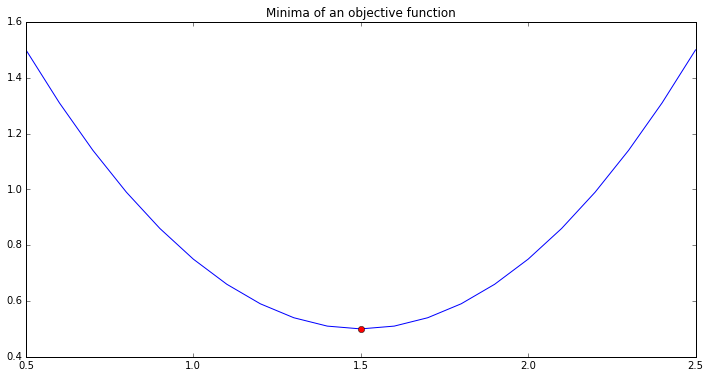

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as spo # scipy optimizer package

def f(X):
    """Given a scalar X, return some value (a real number)."""
    Y = (X - 1.5)**2 + 0.5  # here we define the function
    print "X = {}, y = {}".format(X, Y) # for tracing; print the value each time we get called
    # for understanding what's going on
    
    return Y

def test_run():
    Xguess = 2.0  # set initial guess value
    min_result = spo.minimize(f,                      # call to the optimizer's minimize function
                              Xguess,                 # initial guess
                              method = 'SLSQP',       # particular minimizing algo..expand on later
                              options = {'disp' : True}) 
                              # means we want expanded info as an diagnostic output
    print "Minima found at:"
    print "X = {}, Y = {}".format(min_result.x, min_result.fun)
    
    # Plot function values, mark minima
    Xplot = np.linspace(0.5, 2.5, 21)
    Yplot = f(Xplot)
    plt.plot(Xplot, Yplot)
    plt.plot(min_result.x, min_result.fun, 'ro')
    plt.title("Minima of an objective function")
    plt.show()

if __name__ == "__main__":
    test_run()

**Above you see the guessing pattern of the minimizer as it quickly converges on the answer of 1.5**

<img src='pics/Snap38.jpg' alt='Drawing' style='width: 300pt;'/>

1. No gradient to follow if initial guess on the flat part of the function.
1. One local minima, and two global minima of equal value. 
1. Not hard for the minimizer to solve
1. the discontinuity would be tough, and the flat part.

There are some optimizers that can solve these problems with varying degrees of success. And they're likely to find a minima, just not guaranteed to find the minima.



## Convex function <a id='Convex function'></a>

Type of problems that are particularly easy for algorithms to solve. 

Wikipedia: "... a real-valued function f(x) defined on an interval is called convex if the line segment between any two points on the graph of the function lies above the graph ..."[[link]](http://en.wikipedia.org/wiki/Convex_function)

If the line is above the graph, then the function is convex btn those pts.

* only 1 local and global minima. The middle fn fails for that reason
* we can't have flat regions that don't slope downward


<img src='pics/Snap39.jpg' alt='Drawing' style='width: 300pt;'/>

<img src='pics/Snap40.jpg' alt='Drawing' style='width: 300pt;'/>

##### It's just as easy for these optimizers to work in multiple dimensions.
This one has two dimensions in X. It still has its y result. 

More than one dimension, we can have as many as we'd like.

<img src='pics/Snap41.jpg' alt='Drawing' style='width: 300pt;'/>


## Building a parameterized model <a id='Building a parameterized model'></a>

$f(x) = mx + b $ is an example of a parameter as model that you're probably familiar with from algebra. 

$m$ and $b$ (equation of a line)

for convenience in our code instead of using m and b I'm gonna use $C_0$ and $C_1$ just to be consistent.

Suppose we have some data from an experiment now this can work for many sorts of experiments but for now let's assume we've taken some measurements have humidity and we've observed on those particular days we measure the humidity, how much it rains.

* so each dot here represents one day and one sample data. 

when we look at this data we see there's a kind of relationship here and our intuition is maybe that it could be fitted by a line. 

our task is to find $C_0$ and $C_1$ that provide the equation for this line that best fits the data the question here is how do we frame this problem so that it makes sense for the minimizer. 
* What is it we're trying to minimize? 

<img src='pics/Snap42.jpg' alt='Drawing' style='width: 300pt;'/>

So restating the problem. We're trying to discover the equation of a line that best fits those points. Suppose this blue line is a candidate line and we want to evaluate it. Is this good or bad. So the equation for that line is our first coefficient times $X$ plus the second coefficient and what the minimizer is going to do, is its going to vary this $C_0$ and $C_1$ to try and minimize something. 

* we have to come up with an equation that get lower in value as this line better fits the data. What should we use for that equation. 

* one step toward solving this problem: we can take a look at each one of the  original data points and observe how far away it is from this line that we're evaluating. Let's call each of these distances $e$.

<img src='pics/Snap44.jpg' alt='Drawing' style='width: 300pt;'/>

#### The equation we want the minimizer to minimize is the error (as measured by squared error).

In [41]:
import scipy.optimize as spo

def error(line,data): # error function
    """compute error btn given line model and observed data.
    
    Parameters
    -----------
    line: tuple/list/array (C0, C1) where CO is slope and C1 is Y-intercept
    data: 2d array where each row is a point (x, y)
    
    returns error as a single real value.
    """
    
    # Metric: Sum of squared Y-axis differences
    err = np.sum((data[:, 1] - (line[0] * data[:, 0] + line[1])) ** 2)
    return err

    

In [42]:
def fit_line(data, error_func):
    """fit a line to given data, using a supplied error function.
    
    Parameters
    -----------
    data: 2D array where each row is a point (X0, Y)
    error_func: function that computes the error between a line and observed data
    
    Returns line that minimizes the error function
        """
    
    # Generate inital guess for line model
    l = np.float32([0, np.mean(data[:,1])]) # slope = 0, intercept = mean(y values)
    
    #plot initial guess (optional)
    x_ends = np.float32([-5,5])
    plt.plot(x_ends, 
             l[0] * x_ends + l[1], 
             'm--', linewidth = 2.0, label = "Initial guess")
    
    # call optimizer to minimize error function
    result = spo.minimize(error_func,                 # fn we're trying to minimize (before the _)
                          l,                          # initial guess
                          args=(data,),               # defines how we pass data to our error fn
                          method = 'SLSQP',           # the method we're gonna use
                          options = {'disp' : True})  # set display to true, 
                                                      # so we'll see information during optimization
    return result.x

Original line: C0 = 4.0, C1 = 2.0
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 259.564318908
            Iterations: 5
            Function evaluations: 24
            Gradient evaluations: 5
Fitted line: C0 = 4.07254500109, C1 = 1.63993442294


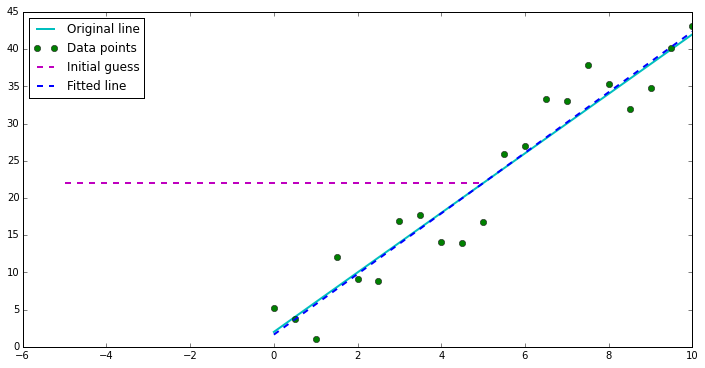

In [158]:
def test_run():
    # Define original line (the minimizer doesn't know this)
    # we're testing to see of the minimizer can discover the equation of this line.
    l_orig = np.float32([4,2]) # slope of 4, y-intercept of 2
    
    # plot original line
    print "Original line: C0 = {}, C1 = {}".format(l_orig[0], l_orig[1])
    Xorig = np.linspace(0, 10, 21)  # generate x values to plug into l_orig
    Yorig = l_orig[0] * Xorig + l_orig[1]  # generate y valuess
    plt.plot(Xorig, Yorig, 'c-', linewidth=2.0, label = "Original line")

    # Generate noisy data points around the original line (l_orig)
    noise_sigma = 3.0
    noise = np.random.normal(0, noise_sigma, Yorig.shape) # use np random fn to generate noise
    data = np.asarray([Xorig, Yorig + noise]).T   # at each point in the data we add some noise
    plt.plot(data[:,0], data[:, 1], 'go', label = "Data points")
    # we're gonna challenge our minimizer to find the equation for the original line even though
    # there's noise

    # Try to fit a line to this data. We wrote a separate fn 
    # fit_line that takes the data and the error fn we defined
    # and finds the eqn for that line.
    l_fit = fit_line(data, error) # data here is noisy data. we took our line and added noise
    # and the error fn. The fn we're trying to minimize
    
    print "Fitted line: C0 = {}, C1 = {}".format(l_fit[0], l_fit[1])
    plt.plot(data[:,0], l_fit[0] * data[:,0] + l_fit[1], 'b--', 
             linewidth = 2.0, label = "Fitted line")
    plt.legend(loc=0)

    
test_run()
    

##### Instructor Notes

Minor comment on output plot: The Initial guess (purple) line has been plotted between different X-axis limits because it is generated from within fit_line() which has no idea about what the intended limits are.

Think of these lines as extending infinitely on either end.


## Polynomials <a id='Polynomials'></a>

In [137]:
def error_poly(C, data):
    """Compute error btn given polynomial and observed data.
    this is the error function we're trying to minimize
    
    Parameters
    ----------
    C: numpy.poly1d object or equivalent array representing polynomial coefficients
    data: 2d array where each row is a point (x,y)
    
    returns error as a single real value."""
    
    # Metric: Sum of squared Y-axis differences
    err = np.sum((data[:, 1] - np.polyval(C, data[:, 0])) ** 2) 
    # sum of the diff btn actual y and polynomial predicted y squared
    
    return err



In [138]:
def fit_poly(data, error_func, degree = 3): # degree of the polynomial
    """Fit a polynomial to given data, using supplied error function
    
    Parameters
    ----------
    data: 2D array where each row is a point (x, y)
    error_func: fn that computes the error btn a polynomial and obberved data
    
    Returns polynomial that minimizes the error fn.
    """
    
    # Generates initial guess for polynomial model (all coeffs = 1)
    Cguess = np.poly1d(np.ones(degree + 1, dtype=np.float32))
    # Cguess = poly1d([ 1.,  1.,  1.,  1.], dtype=float32)
    
    # Plot initial guess (optional)
    x = np.linspace(-5, 5, 21) # Return evenly spaced numbers over a specified interval
    plt.plot(x, np.polyval(Cguess, x), 'm--', linewidth = 2.0, label = 'Initial guess')
    
    result = spo.minimize(error_func,                 # fn we're trying to minimize
                          Cguess,                     # initial guess
                          args=(data,),               # defines how we pass data to our error fn
                          method = 'SLSQP',           # the method we're gonna use
                          options = {'disp' : True})  # set display to true, 
                                                      # so we'll see more information
        
    return np.poly1d(result.x) # convert optimal result into a poly1d object and return

Original polynomial:
     4      3     2
1.5 x - 10 x - 5 x + 60 x + 50
noise:  [-43.90303892  -2.82859238  32.5436962   16.48613584   0.36523117
  41.11436461  45.709224   -36.85350284 -22.94504675 -21.27419797
  -7.87445777  22.88614635 -10.185754    -2.2064181   36.89975049
  34.1101085  -15.73520313  66.87570992  48.40920145 -31.02372314
  18.45059016]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 13107.6921994
            Iterations: 8
            Function evaluations: 74
            Gradient evaluations: 8
Fitted polynomial: 
       4        3         2
1.211 x - 9.91 x + 1.742 x + 60.74 x + 39.77


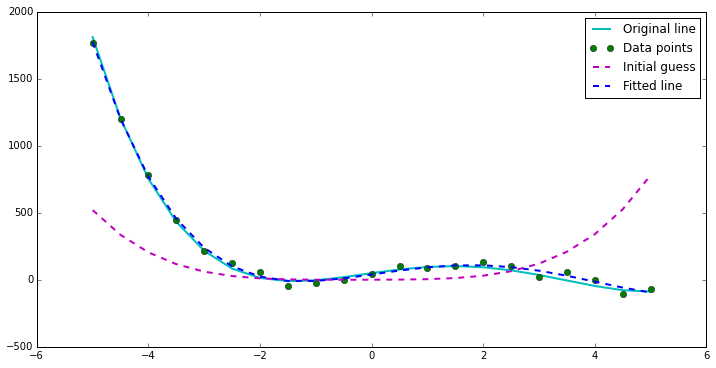

In [163]:
def test_run():
    # Define original line (the minimizer doesn't know this)
    # we're testing to see of the minimizer can discover the following equation.
    l_orig = np.poly1d([1.5, -10, -5, 60, 50])
    
    # plot the original line
    print "Original polynomial:"
    print l_orig
    Xorig = np.linspace(-5, 5, 21)     # x values passed to original line
    Yorig = np.polyval(l_orig, Xorig)  # associated y values of original line
    plt.plot(Xorig, Yorig, 
             'c-', linewidth=2.0, label = "Original line")

    # Generate noisy data points around the original line (l_orig)
    noise_sigma = 3.0
    noise = np.random.normal(0, noise_sigma, Yorig.shape) * 10
    # use np random fn to generate noise
    print "noise: ", noise
    
    data = np.asarray([Xorig, Yorig + noise]).T   
    # at each point in the data we add some noise
    
    plt.plot(data[:,0], data[:, 1], 'go', label = "Data points")
    # we're gonna challenge our minimizer to find the equation for the original line even though
    # there's noisex

    # Try to fit a line to this data. We wrote a separate fn 
    # fit_line that takes the data and the error fn we defined
    # and finds the eqn for that line.
    l_fit = fit_poly(data, error_poly, degree = 4) # data here is noisy data. we took our line and added noise
    # and the error fn. The fn we're trying to minimize
  
   
    print "Fitted polynomial: "
    print l_fit
    plt.plot(data[:,0], 
             np.polyval(l_fit, data[:,0]),
             'b--', 
             linewidth = 2.0, 
             label = "Fitted line")
    plt.legend(loc=0)

    
test_run()
    

In [68]:
# ??np.linspace()
# np.poly1d(np.ones(3 + 1, dtype=np.float32))
print np.poly1d([1.5, 10, 5, 60, 50])
# ??np.poly1d()

     4      3     2
1.5 x + 10 x + 5 x + 60 x + 50


### Code Playground

In [84]:
np.linspace(-5, 5, 21)
# l_orig

array([-5. , -4.5, -4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,
        0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ])